In [1]:
# https://qiita.com/JUN_NETWORKS/items/c2f94f1775b6156b0105
# conda install pillow==6.2.1
# pillow の最新バージョン(7.0)だとエラーがでる（2020/01/09）
# conda install -c pytorch torchvision
# conda install pytorch torchvision cudatoolkit=10.1 -c pytorch --> gpuがある場合

import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# CIFAR-10をMLPで画像分類

## データの読み込み

In [2]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=False, 
                                             transform=transforms.ToTensor(),
                                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=2)

In [5]:
for images, labels in train_loader:
    print(images.size())
    print(images[0].size())
    print(labels.size())
    break

torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([64])


## ネットワークを定義

In [6]:
num_classes = 10

class MLPNet (nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 600)
        self.fc2 = nn.Linear(600, 600)
        self.fc3 = nn.Linear(600, num_classes)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return F.relu(self.fc3(x))

# pytorchはGPUを使うかをコードで制御する。これで使うデバイスをGPUかCPUかを決定できる。
GPU = True
#device = torch.device("cuda" if GPU else "cpu")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MLPNet().to(device)

In [7]:
torch.cuda.is_available()

True

In [8]:
net

MLPNet(
  (fc1): Linear(in_features=3072, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=10, bias=True)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
)

## 損失関数と最適化関数

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

## 訓練

In [10]:
#50エポック
num_epochs = 50

#最後にlossとaccuracyのグラフをプロットするためのリスト
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    #エポックごとに初期化
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train==============================
    #訓練モードへ切り替え
    net.train()
    #ミニバッチで分割して読み込む
    for i, (images, labels) in enumerate(train_loader):
      #viewで縦横32ピクセルで3チャンネルの画像を１次元に変換
      #toでgpuに転送
      images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)

      #勾配をリセット
      optimizer.zero_grad()
      #順伝播の計算
      outputs = net(images)
      #lossの計算
      loss = criterion(outputs, labels)
      #lossのミニバッチ分を溜め込む
      train_loss += loss.item()
      #accuracyをミニバッチ分を溜め込む
      #正解ラベル（labels）と予測値のtop1（outputs.max(1)）が合っている場合に1が返ってきます。
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      #逆伝播の計算
      loss.backward()
      #重みの更新
      optimizer.step()
    #平均lossと平均accuracyを計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val==============================
    #評価モードへ切り替え
    net.eval()
    #評価するときに必要のない計算が走らないようにtorch.no_gradを使用しています。
    with torch.no_grad():
      for images, labels in test_loader:        
        images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    #訓練データのlossと検証データのlossとaccuracyをログで出しています。
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    #最後にグラフをプロットするようにリストに格納
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/50], Loss: 0.0307, val_loss: 0.0279, val_acc: 0.3609
Epoch [2/50], Loss: 0.0276, val_loss: 0.0267, val_acc: 0.3948
Epoch [3/50], Loss: 0.0265, val_loss: 0.0251, val_acc: 0.4386
Epoch [4/50], Loss: 0.0258, val_loss: 0.0246, val_acc: 0.4430
Epoch [5/50], Loss: 0.0251, val_loss: 0.0243, val_acc: 0.4536
Epoch [6/50], Loss: 0.0247, val_loss: 0.0237, val_acc: 0.4638
Epoch [7/50], Loss: 0.0242, val_loss: 0.0242, val_acc: 0.4509
Epoch [8/50], Loss: 0.0239, val_loss: 0.0234, val_acc: 0.4671
Epoch [9/50], Loss: 0.0236, val_loss: 0.0237, val_acc: 0.4655
Epoch [10/50], Loss: 0.0234, val_loss: 0.0227, val_acc: 0.4834
Epoch [11/50], Loss: 0.0231, val_loss: 0.0225, val_acc: 0.4864
Epoch [12/50], Loss: 0.0229, val_loss: 0.0226, val_acc: 0.4879
Epoch [13/50], Loss: 0.0226, val_loss: 0.0222, val_acc: 0.4953
Epoch [14/50], Loss: 0.0225, val_loss: 0.0225, val_acc: 0.4850
Epoch [15/50], Loss: 0.0223, val_loss: 0.0220, val_acc: 0.5004
Epoch [16/50], Loss: 0.0222, val_loss: 0.0223, val_acc: 0.4903
E

## 結果をプロット

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


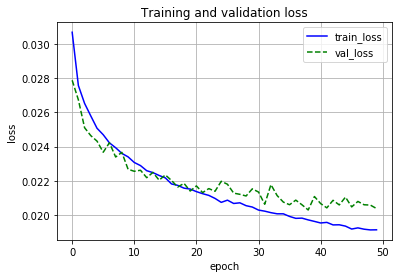

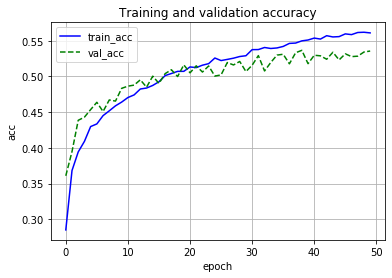

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

In [12]:
# ネットワークを保存する
torch.save(net.state_dict(), 'net.ckpt')

In [13]:
# ネットワークを読み込む
net2 = MLPNet().to(device)
net2.load_state_dict(torch.load('net.ckpt'))

<All keys matched successfully>

## 推論

In [14]:
net2.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
        outputs = net2(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('精度: {} %'.format(100 * test_acc / total)) 

精度: 53.56 %


In [15]:
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('精度: {} %'.format(100 * test_acc / total)) 

精度: 53.56 %
